# Descartes - Technical Test
Ludovic Pailloux

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## I - Opening files and first exploration

We open the datasets using the library pandas and have a first look on the data.
We realise that the column index doesn't give any information so we remove it. We also realise that the variable "TARGET_AMT" is not given in the test set. Our goal is only to predict the variable "TARGET_FLAG" so we remove this other variable. 

(Actually we could predict both if it was the objective)

In [2]:
# Load datasets
train_auto = pd.read_csv("auto-insurance-fall-2017/train_auto.csv")
test_auto = pd.read_csv("auto-insurance-fall-2017/test_auto.csv")

# Remove useless columns
train_auto = train_auto.drop(columns=["INDEX","TARGET_AMT"])
test_auto = test_auto.drop(columns=["INDEX","TARGET_AMT","TARGET_FLAG"])

# Variables name
X_names = list(test_auto.columns)
Y_name = "TARGET_FLAG"

# Merge the data for the preprocessing part
train_and_test = pd.concat([train_auto[X_names],test_auto],ignore_index=True)

# Basic information about the data
print("There are "+str(len(train_auto))+" rows in the train set and "+str(len(test_auto))+" in the test set. \n"+
      "There are "+str(len(test_auto.columns))+" attributes:")
print(X_names)
print("There is one variable to predict : "+Y_name)
train_auto.head()

There are 8161 rows in the train set and 2141 in the test set. 
There are 23 attributes:
['KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR', 'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY']
There is one variable to predict : TARGET_FLAG


,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


Knowing that TARGET_FLAG has to be predict by our model, we cannot keep rows with missing value for the variable. Thus, we take a first look at its distribution.  

0 Na value in TARGET_FLAG column


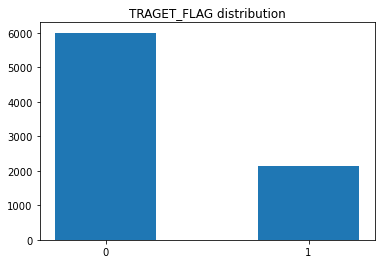

In [3]:
print(str(sum(pd.isna(train_auto["TARGET_FLAG"])))+" Na value in TARGET_FLAG column")
Y_train = list(train_auto["TARGET_FLAG"])
# Bar Plot for the targeted variable
plt.bar(["0","1"],[Y_train.count(0),Y_train.count(1)],width=0.5)
plt.title("TRAGET_FLAG distribution")
plt.show()

## II - Preprocessing

I decided to merge both the training and the testing set for this part. In fact, if we suppose that every row is a variable following one law, we now have more observation and thus reduce the error around our future mean estimators.

We now study each variable to convert non digital variable and replace missing values. I have decided to simply replace missing value by the mean value of the variable. For categorical variables, we consider that missing values are actually part of the biggest class.

### II - 1. Replace $ values by figures

We start with money values (4 columns) expressed in $ which can be easily convert to float values.

In [4]:
DOLLAR_COL = ["INCOME","HOME_VAL","BLUEBOOK","OLDCLAIM"] # names of the variable expressed with a $ sign

for dollar_col in DOLLAR_COL:
    newcol = []
    for i in range(len(train_and_test)):
        val = train_and_test.loc[i,dollar_col]
        if isinstance(val,str):
            newcol += [int(val.replace("$","").replace(",",""))] # convert string into integers
        else:
            newcol += [np.nan]
    train_and_test[dollar_col] = newcol

train_and_test[DOLLAR_COL].head()

,INCOME,HOME_VAL,BLUEBOOK,OLDCLAIM
0,67349.0,0.0,14230,4461
1,91449.0,257252.0,14940,0
2,16039.0,124191.0,4010,38690
3,NaN,306251.0,15440,0
4,114986.0,243925.0,18000,19217


### II - 2. Categorial variables

Usually we use one hot encoding to deal with categorial variables. However, in some cases it is not not necessary to refer to such methods (when there are only two possibilities) or it can be inappropriate (when we want to preserve a semantic progression eg. *small*, *medium*, *tall*).

#### II - 2 - 1.  Binary variables
We start with categorial variables with only two possible values. We just have to replace one value by 0 and the other one by 1.

In [5]:
# names of categorial colums (index 2 was chosen because it contains no Nan values)
CATEGORIAL_COL = np.array(X_names)[[isinstance(train_and_test.loc[2,col],str) for col in X_names]]
BINARY_COL = CATEGORIAL_COL[[len(train_and_test[col].unique())<=2 for col in CATEGORIAL_COL]]

print(str(len(CATEGORIAL_COL))+" categorial variables including "+str(len(BINARY_COL))+" binary variables")

for col in BINARY_COL:
    # we recover different levels
    choices = train_and_test[col].unique() # we noticed that the len of choices is always equal to 2
    new_col = [int(train_and_test.loc[idx,col].replace(choices[0],'0').replace(choices[1],'1')) for idx in range(len(train_and_test))]
    train_and_test[col] = new_col

train_and_test[BINARY_COL].head()

10 categorial variables including 7 binary variables


,PARENT1,MSTATUS,SEX,CAR_USE,RED_CAR,REVOKED,URBANICITY
0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0
2,0,1,1,0,1,0,0
3,0,1,0,0,0,0,0
4,0,1,1,0,1,1,0


#### II - 2 - 2. Other Categorial Variables
We first display the different values taken by the remaining categorial variables to decide if we apply one hot encoding transformation or not.
At this stage, we have observed that there is no missing value in any categorial variable, except for *JOB*.

It appears that Education contains a certain progression that we will maintain. I make the hypothesis that *z_High School* stands for *High School*.

According to this source: http://www.differencebetween.net/miscellaneous/difference-between-diploma-and-bachelor/#:~:text=For%20pursuing%20a%20Bachelor%E2%80%99s%20degree%2C%20a%20student%20must,Master%E2%80%99s%20degree%20with%20only%20a%20diploma%20in%20hand, the progression should be: $\textit{<High School}$, $\textit{z_High School}$, $\textit{Bachelors}$, $\textit{Masters}$ and $\textit{PhD}$.

In [6]:
CATEGORIAL_NON_BINARY = list(CATEGORIAL_COL[[col not in BINARY_COL for col in CATEGORIAL_COL]])
for col in CATEGORIAL_NON_BINARY:
    print(col)
    print(train_and_test[col].unique())

# New Education column with numrical values
new_education_col = [int(train_and_test.loc[idx,'EDUCATION'].replace('PhD','4').replace('Masters','3')
                     .replace('Bachelors','2').replace('z_High School','1').replace('<High School','0')) 
                     for idx in range(len(train_and_test))]

train_and_test['EDUCATION'] = new_education_col

CATEGORIAL_OTHER = ['JOB','CAR_TYPE'] # we apply one hot encoding on those variables 

# Before we use one hot encoding we replace missing value in JOB
most_present_value = train_and_test['JOB'][np.invert(train_and_test['JOB'].isna())].value_counts().index[0]
train_and_test['JOB'][train_and_test['JOB'].isna()] = most_present_value

# We now procede to one hot encoding for both JOB and CAR_TYPE
train_and_test = pd.get_dummies(train_and_test, columns = CATEGORIAL_OTHER )

# We have just added more column
train_and_test.head()

EDUCATION
['PhD' 'z_High School' '<High School' 'Bachelors' 'Masters']
JOB
['Professional' 'z_Blue Collar' 'Clerical' 'Doctor' 'Lawyer' 'Manager' nan
 'Home Maker' 'Student']
CAR_TYPE
['Minivan' 'z_SUV' 'Sports Car' 'Van' 'Panel Truck' 'Pickup']


<ipython-input-6-cd7b05f8e801>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_and_test['JOB'][train_and_test['JOB'].isna()] = most_present_value


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,...,JOB_Manager,JOB_Professional,JOB_Student,JOB_z_Blue Collar,CAR_TYPE_Minivan,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_Van,CAR_TYPE_z_SUV
0,0,60.0,0,11.0,67349.0,0,0.0,0,0,4,...,0,1,0,0,1,0,0,0,0,0
1,0,43.0,0,11.0,91449.0,0,257252.0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
2,0,35.0,1,10.0,16039.0,0,124191.0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
3,0,51.0,0,14.0,NaN,0,306251.0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,50.0,0,NaN,114986.0,0,243925.0,1,1,4,...,0,0,0,0,0,0,0,0,0,1


We note that 35 columns after the transformation is consistent with the fact that we had 23 columns and we have added 8 (nb of JOB class) + 6 (nb of CAR_TYPE class) = 14 columns and removed JOB and CAR_TYPE. At the end of the day, we have 24-2+14=35 columns.

### II - 3. Missing values

We have already dealt with categorial variables. There still remain the numerical and former in-$ variables. Five of them contain nan values. As explained at the beginning of the study, I have decided to replace those by the mean of the variable.

In [7]:
NUMERICAL_COL = np.array(X_names)[[col not in CATEGORIAL_COL for col in X_names]] # no former categorial columns 
NUMERICAL_COL_MISS = [] # list of columns containing missing values
for col in NUMERICAL_COL:
    nb_missing_values = sum(train_and_test[col].isna()) # number of missing values
    if nb_missing_values>0:
        NUMERICAL_COL_MISS += [col]

for col in NUMERICAL_COL_MISS:
    mean_col = np.mean(train_and_test[col]) # value we use to replace missing value 
    train_and_test[col] = train_and_test[col].fillna(mean_col) # fill missing value using the mean of the distribution

## III - Distributions and correlations

We are going to have a look on the distributions of the variables and on the correlations between them.

### III - 1 Histograms

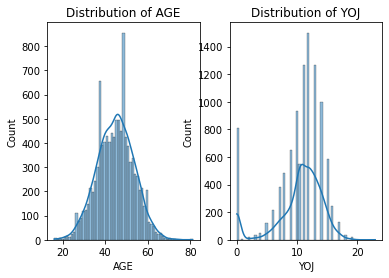

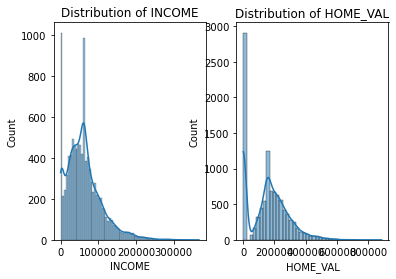

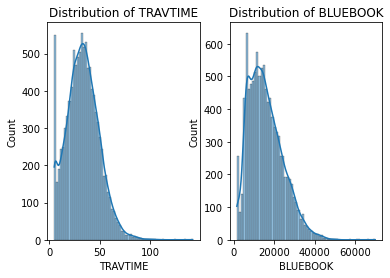

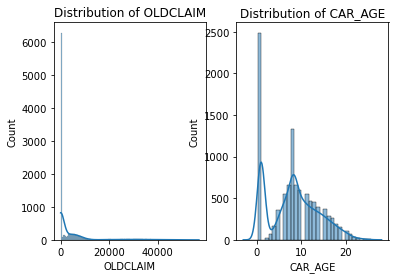

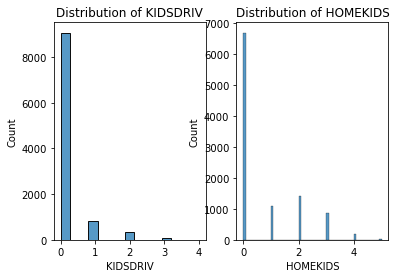

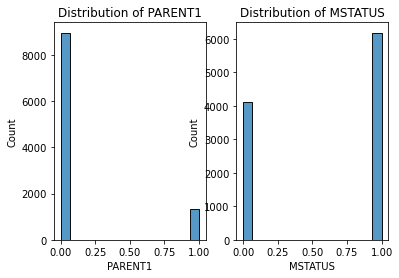

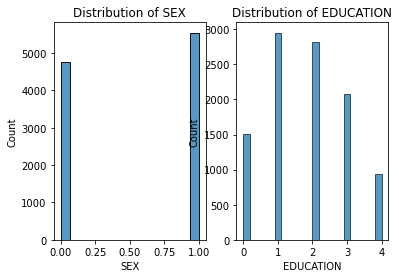

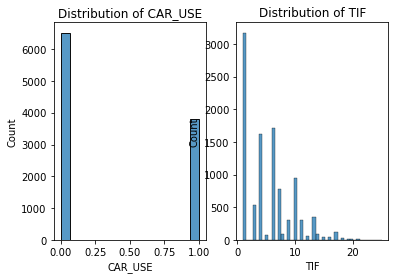

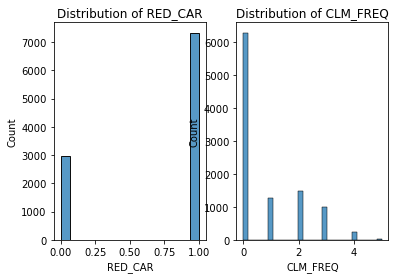

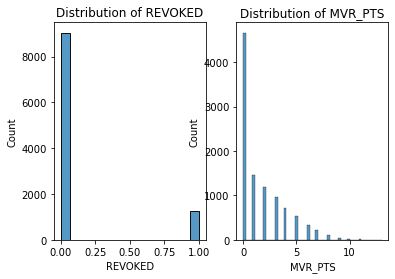

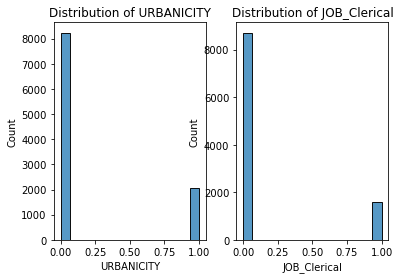

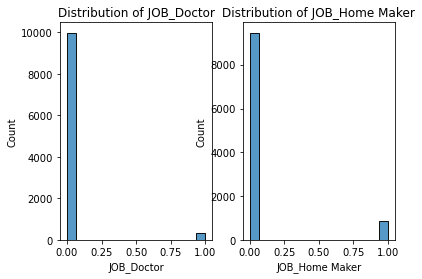

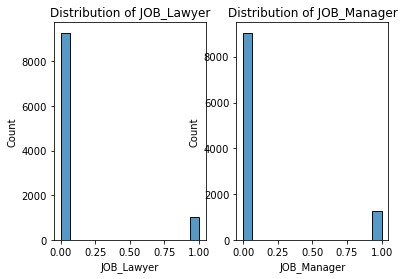

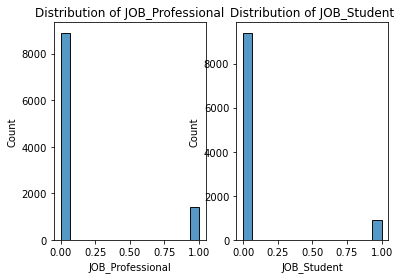

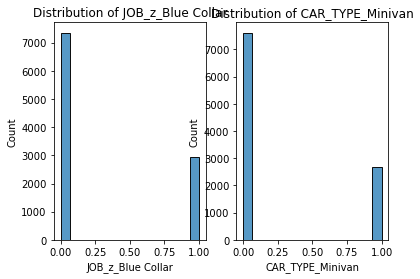

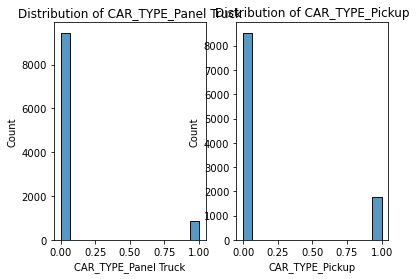

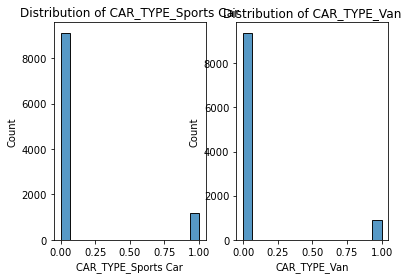

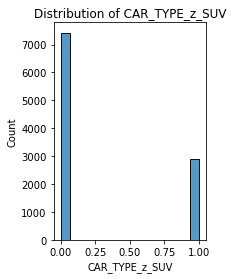

In [8]:
import seaborn as sns

continuous_columns = ["AGE",'YOJ','INCOME','HOME_VAL',"TRAVTIME",'BLUEBOOK','OLDCLAIM','CAR_AGE']
categorial_columns = np.array(train_and_test.columns)[[col not in continuous_columns for col in train_and_test.columns]]

k = 0 # variable to diplay two histogram side by side
for col in continuous_columns:
    k += 1
    plt.subplot(1,2,k) # position for the following plot
    k = k%2
    sns.histplot(x=train_and_test[col],kde=True)
    plt.title('Distribution of '+ col)
    if k%2==0:
        plt.show()
        
k = 0 # variable to diplay two histogram side by side
for col in categorial_columns:
    k += 1
    plt.subplot(1,2,k) # position for the following plot
    k = k%2
    sns.histplot(x=train_and_test[col])
    plt.title('Distribution of '+ col)
    if k%2==0:
        plt.show() 

After having display those distribution, I have realized that a certain amount of people (2908) declared a value of their house equal to 0. I decided not to modify it, assuming that it is a particular profile of clients: tenants.

I also assume that persons with no income (797) may be an other particular profile: students...

### III - 2. Scaling and Correlations

At this step, we scale the data using RobustScaler, split again the data to recover the former train and test sets.

For readability reasons, we only keep continuous variable for correlations visualisation.

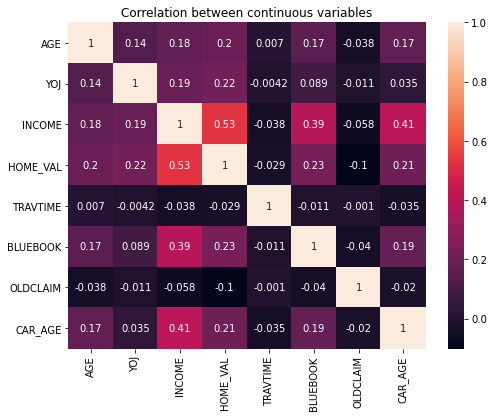

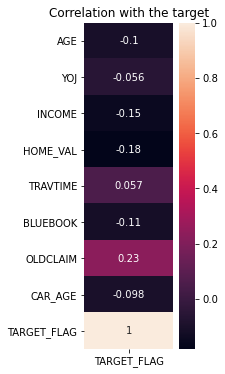

In [9]:
from sklearn.preprocessing import RobustScaler
import copy 

# Scale the data
scaler = RobustScaler()
scaler.fit(train_and_test)
train_and_test_scaled = scaler.transform(train_and_test)
train_and_test_scaled = pd.DataFrame(train_and_test_scaled,columns=train_and_test.columns)

# Split to recover our initial train and test set
TRAIN_SET = train_and_test_scaled.iloc[:8161,:]
TEST_SET = train_and_test_scaled.iloc[8161:,:]

Y_TRAIN = train_auto[Y_name]

# train set with both attributes and the targeted variable
FULL_TRAIN_SET = copy.copy(TRAIN_SET)
FULL_TRAIN_SET[Y_name] = train_auto[Y_name]

# Visualisation of correlations between data
corr_df = TRAIN_SET[continuous_columns].corr(method='spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.title('Correlation between continuous variables')
plt.show()

# Correlation with the target
corr_target = pd.DataFrame(FULL_TRAIN_SET[continuous_columns+[Y_name]].corr(method='spearman')[Y_name])
plt.figure(figsize=(2, 6))
sns.heatmap(corr_target, annot=True)
plt.title("Correlation with the target")
plt.show()

We do not observe high correlations between the continuous variables and the target flag. 

## IV - Models selection

We implement different models to predict TARGET_FLAG for the TEST_SET.
We compare different scores linked to their performance:
- accuracy : percentage of good prediction
- precision : share of true positive among positive predictions (true positive and false positive)
- recall : share of true positive among real positive (true positive and false negative)
- fscore : harmonic mean between recall and precision

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Metrics used to compare models
scores_metric = ["Accuracy","Precision","Recall","F-score"]
# Classifier used to buid models
list_classifier = ["Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting", "KNN 5", "KNN 11", "Logistic Regression",
                   "SVM", "NN 5-5-5", "NN 10-10-10", "NN 20-15-10"]
# list of metrics for every model
pred_models = [np.array([.0]*len(scores_metric))]*len(list_classifier)

N_cv = 10
for k in range(N_cv):
    # From train_auto, we build a training and an evaluating set
    X_train, X_valid, Y_train, Y_valid = train_test_split(TRAIN_SET, Y_TRAIN, train_size=0.80)
    
    def metrics_model(pred,ref=Y_valid):
        acc = accuracy_score(ref,pred)
        prec,rec,fsc,_ = precision_recall_fscore_support(ref,pred,average='weighted')
        return np.array([round(acc,4),round(prec,4),round(rec,4),round(fsc,4)])
    
    # Decision Tree
    from sklearn.tree import DecisionTreeClassifier
    decision_tree = DecisionTreeClassifier().fit(X_train, Y_train)
    pred_models[0] = metrics_model(decision_tree.predict(X_valid))+pred_models[0]

    # Random Forest
    from sklearn.ensemble import RandomForestClassifier
    random_forest = RandomForestClassifier().fit(X_train, Y_train)
    pred_models[1] = metrics_model(random_forest.predict(X_valid)) + pred_models[1]

    #Adaboost
    from sklearn.ensemble import AdaBoostClassifier
    ada = AdaBoostClassifier().fit(X_train, Y_train)
    pred_models[2] = metrics_model(ada.predict(X_valid)) + pred_models[2]

    # Gradient Boosting
    from sklearn.ensemble import GradientBoostingClassifier
    grad = GradientBoostingClassifier().fit(X_train, Y_train)
    pred_models[3] = metrics_model(grad.predict(X_valid)) + pred_models[3]

    # KNN 
    from sklearn.neighbors import KNeighborsClassifier
    # 5 neighboors
    knn5 = KNeighborsClassifier(n_neighbors=5).fit(X_train, Y_train)
    pred_models[4] = metrics_model(knn5.predict(X_valid)) + pred_models[4]

    # 11 neighboors
    knn11 = KNeighborsClassifier(n_neighbors=11).fit(X_train, Y_train)
    pred_models[5] = metrics_model(knn11.predict(X_valid)) + pred_models[5]

    # Logistic Regression
    from sklearn.linear_model import LogisticRegression
    logreg = LogisticRegression().fit(X_train, Y_train)
    pred_models[6] = metrics_model(logreg.predict(X_valid)) + pred_models[6]

    # SVM
    from sklearn.svm import SVC
    svm = SVC().fit(X_train, Y_train)
    pred_models[7] = metrics_model(svm.predict(X_valid)) + pred_models[7]

    # Neural Network
    from sklearn.neural_network import MLPClassifier
    # hidden layers size 5
    mlp5 = MLPClassifier(hidden_layer_sizes=(5,5,5)).fit(X_train, Y_train)
    pred_models[8] = metrics_model(mlp5.predict(X_valid)) + pred_models[8]

    # hidden layers size 10
    mlp10 = MLPClassifier(hidden_layer_sizes=(10,10,10)).fit(X_train, Y_train)
    pred_models[9] = metrics_model(mlp10.predict(X_valid)) + pred_models[9]

    # hidden layers decreasing size
    mlp = MLPClassifier(hidden_layer_sizes=(20,15,10)).fit(X_train, Y_train)
    pred_models[10] = metrics_model(mlp.predict(X_valid)) + pred_models[10]

# Normalize our scores (5 additions)
pred_models = [np.round(pred_models[k]/N_cv,3) for k in range(len(pred_models))]

results = pd.DataFrame(pred_models, index=list_classifier, columns=scores_metric)
#results.to_csv("Models_scores.csv")
results

C:\Users\ludov\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ludov\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ludov\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ludov\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ludov\anaconda3\lib\site-packages\sklearn\neural_network\_multi

,Accuracy,Precision,Recall,F-score
Decision Tree,0.706,0.711,0.706,0.708
Random Forest,0.788,0.774,0.788,0.764
AdaBoost,0.788,0.773,0.788,0.774
Gradient Boosting,0.796,0.783,0.796,0.780
KNN 5,0.743,0.717,0.743,0.722
KNN 11,0.760,0.733,0.760,0.730
Logistic Regression,0.788,0.773,0.788,0.772
SVM,0.790,0.775,0.790,0.767
NN 5-5-5,0.785,0.772,0.785,0.774
NN 10-10-10,0.777,0.767,0.777,0.769


We select the model with the highest f-score and accuracy after having run every models with a cross validation of 10, that is to say Gradient Boosting model for the follwing performance:
- accuracy = 0.790
- precision = 0.776
- recall = 0.790
- fscore = 0.772

## V - Prediction

We run this model on the whole training set. Once built, we use it to predict the variable TARGET_FLAG for the dataset test_auto.

In [11]:
gradboost = GradientBoostingClassifier().fit(TRAIN_SET, Y_TRAIN)
predictions = gradboost.predict(TEST_SET)
# we add the prediction for TARGET_FLAG in the datset
TEST_SET[Y_name] = predictions
#TEST_SET.to_csv("Predictions.csv")

<ipython-input-11-bf6d75c8e3fc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TEST_SET[Y_name] = predictions
